In [ ]:
!pip install tensorflow Pillow scikit-learn matplotlib
!pip install tensorflow
!pip install albumentations
!pip install numpy pandas
!pip install geopandas rasterio
!pip install folium
!pip install --upgrade Pillow
!pip list

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.2 MB/s eta 0:00:00
Package                            Version
---------------------------------- -------------------
absl-py                            1.4.0
accelerate                         1.3.0
affine                             2.4.0
aiohappyeyeballs                   2.4.6
aiohttp                            3.11.12
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.4
ale-py                             0.10.1
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            7.0.1
astropy-iers-data                  0.2025.2.10.0.33.26
astunparse             

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50  # Or another pre-trained model
import matplotlib.pyplot as plt

In [ ]:
deforested_dir = "/content/dataset/deforestation"
no_deforested_dir = "/content/dataset/no_deforestation"

In [ ]:
img_height, img_width = 128, 128
input_shape = (img_height, img_width, 3)

def load_and_preprocess_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            img_path = os.path.join(directory, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize((img_height, img_width))
                img_array = np.array(img) / 255.0
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                print(f"Error processing image {filename}: {e}")
    return np.array(images), np.array(labels)

In [ ]:
deforested_images, deforested_labels = load_and_preprocess_images(deforested_dir, 1)
no_deforested_images, no_deforested_labels = load_and_preprocess_images(no_deforested_dir, 0)

all_images = np.concatenate((deforested_images, no_deforested_images), axis=0)
all_labels = np.concatenate((deforested_labels, no_deforested_labels), axis=0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Split training data for validation
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train_new)

# Model Building (ResNet50 example)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

In [ ]:
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Training with Data Augmentation and Callbacks
epochs = 50
batch_size = 32

In [ ]:
history = model.fit(datagen.flow(X_train_new, y_train_new, batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[lr_scheduler, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 7s/step - accuracy: 0.4650 - loss: 2.5689 - val_accuracy: 0.5000 - val_loss: 1.3897 - learning_rate: 0.0010
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step - accuracy: 0.4946 - loss: 2.2355 - val_accuracy: 0.5000 - val_loss: 3.4420 - learning_rate: 0.0010
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.5094 - loss: 2.8736 - val_accuracy: 0.5000 - val_loss: 1.3059 - learning_rate: 0.0010
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.5875 - loss: 1.0800 - val_accuracy: 0.5000 - val_loss: 1.7369 - learning_rate: 0.0010
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.4393 - loss: 1.9057 - val_accuracy: 0.5000 - val_loss: 1.3032 - learning_rate: 0.0010
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4734 - loss: 1.2791 - val_accuracy: 0.5000 - val_loss: 0.9681 - learning_rate: 0.0010
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 3s/step - accuracy: 0.4838 - loss: 1.2468 - val_accuracy: 0.5000 - val_loss: 1

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Save the model
model.save("/content/new/deforestation_classifier.h5")

Test Loss: 0.6548
Test Accuracy: 0.5385


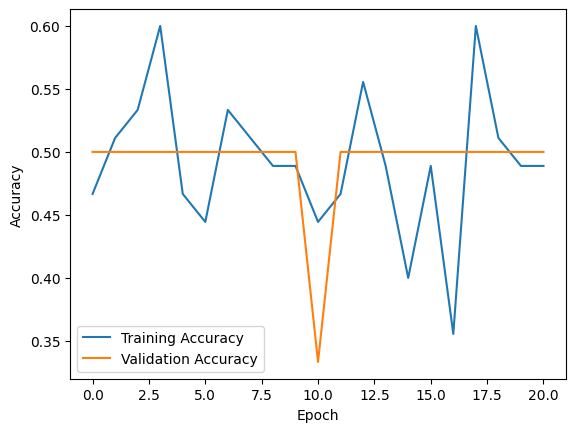

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

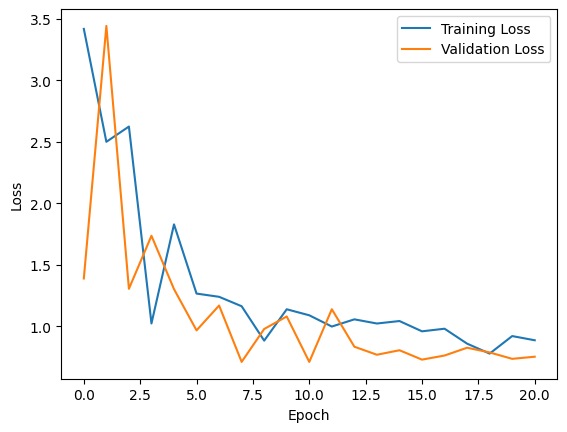

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()